In [17]:
import os
import yaml
from glob import glob
from tqdm import tqdm
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import make_lupton_rgb

from mejiro.synthetic_image import SyntheticImage
from mejiro.exposure import Exposure
from mejiro.instruments.hst import HST
from mejiro.instruments.roman import Roman
from mejiro.instruments.lsst import LSST
from mejiro.instruments.hwo import HWO
from mejiro.utils import util

# read configuration file
with open('/grad/bwedig/mejiro/projects/pipeline/hwo.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

In [18]:
if config['dev']:
    config['pipeline_label'] += '_dev'

In [19]:
lenses = util.unpickle_all(os.path.join(config['data_dir'], config['pipeline_label'], '02'))
print(f'Found {len(lenses)} strong lens(es)')

name_snr_pairs = util.unpickle('/data/bwedig/mejiro/hwo/snr/name_snr_pairs.pkl')
snr_dict = dict(name_snr_pairs)

# Sort lenses by SNR, matching on exposure.synthetic_image.strong_lens.name
sorted_lenses = sorted(
    lenses,
    key=lambda lens: snr_dict.get(lens.name, -np.inf),
    reverse=True
)

Found 415 strong lens(es)


In [40]:
print(snr_dict)

{'hwo_00000105': 1135.225656242168, 'hwo_00000200': 870.5439535068108, 'hwo_00000220': 286.12114470891385, 'hwo_00000005': 247.9612428819445, 'hwo_00000244': 201.30116875343424, 'hwo_00000170': 297.61719484481404, 'hwo_00000293': 246.63311090923725, 'hwo_00000382': 287.19158555089837, 'hwo_00000231': 491.247509693775, 'hwo_00000239': 367.5275037773806, 'hwo_00000370': 321.0429995008411, 'hwo_00000632': 471.6016978064157, 'hwo_00000565': 384.8074538308667, 'hwo_00001385': 296.83801372923153, 'hwo_00000025': 651.8161297606053, 'hwo_00001363': 293.1913366155187, 'hwo_00001440': 260.302107547937, 'hwo_00001296': 700.6981255702597, 'hwo_00001444': 262.92721140034524, 'hwo_00000408': 788.5467727229412, 'hwo_00001549': 498.02411418365324, 'hwo_00000536': 357.3275442656887, 'hwo_00000882': 316.7991863387021, 'hwo_00001535': 597.2318388920496, 'hwo_00000655': 383.8422224947091, 'hwo_00001557': 570.7741781075255, 'hwo_00001509': 1212.65734306466, 'hwo_00000515': 423.83153512713017, 'hwo_00000306

In [41]:
sample = sorted_lenses[0]
pprint(sample.physical_params['magnitudes'])

{'lens': {'B': 23.055390253038865,
          'F062': 22.29863200059792,
          'F087': 20.79017624795238,
          'F106': 20.131511891806895,
          'F129': 19.72263136475464,
          'F146': 19.575559719919504,
          'F158': 19.37721169252032,
          'F184': 19.132510306056908,
          'F213': 18.90319406806141,
          'F438W': 23.042363357544083,
          'F475W': 23.032051869278334,
          'F606W': 22.54919293662632,
          'F814W': 21.22402242146741,
          'FUV': 23.45549439383086,
          'H': 19.362491515548278,
          'I': 20.963264348835907,
          'J': 19.755919506322464,
          'K': 18.87698635778152,
          'NUV': 23.223248606372394,
          'R': 21.469598849355812,
          'U': 23.232043668526217,
          'V': 22.496069249877465,
          'g': 23.030898687334044,
          'i': 21.637522373405552,
          'r': 22.38885110367454,
          'u': 23.152946074083815,
          'y': 20.336300957654373,
          'z': 20.812

Scene size: 5.001921551492087 arcsec, 291 pixels at pixel scale 0.017188733853924696 arcsec/pix


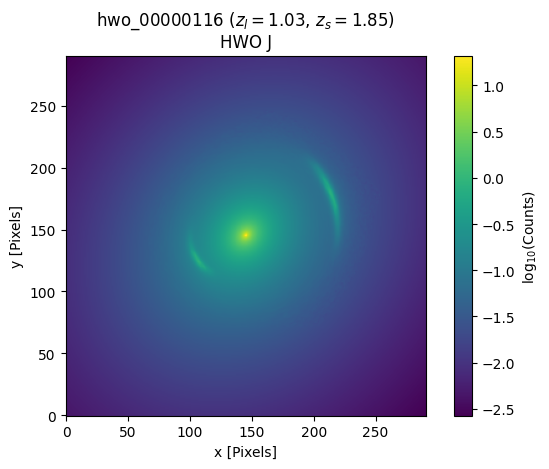

In [42]:
synthetic_image_hwo = SyntheticImage(strong_lens=sample,
                                     instrument=HWO(),
                                     band='J',
                                     verbose=True)
synthetic_image_hwo.plot()

Scene size: 5.04 arcsec, 63 pixels at pixel scale 0.08 arcsec/pix


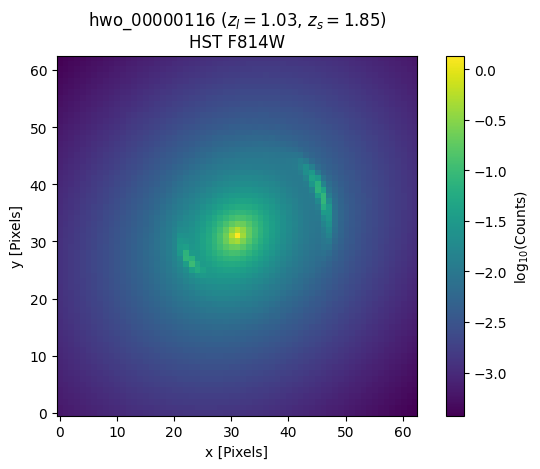

In [43]:
synthetic_image_hst = SyntheticImage(strong_lens=sample,
                                 instrument=HST(),
                                 band='F814W',
                                 verbose=True)
synthetic_image_hst.plot()

Scene size: 5.17 arcsec, 47 pixels at pixel scale 0.11 arcsec/pix


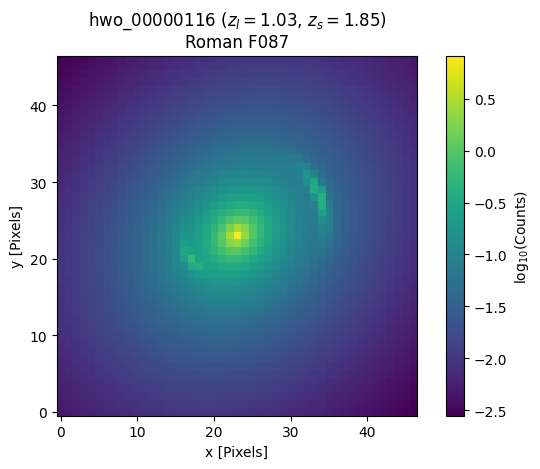

In [44]:
synthetic_image_roman = SyntheticImage(strong_lens=sample,
                                 instrument=Roman(),
                                 band='F087',
                                 verbose=True)
synthetic_image_roman.plot()

Scene size: 5.0 arcsec, 25 pixels at pixel scale 0.2 arcsec/pix


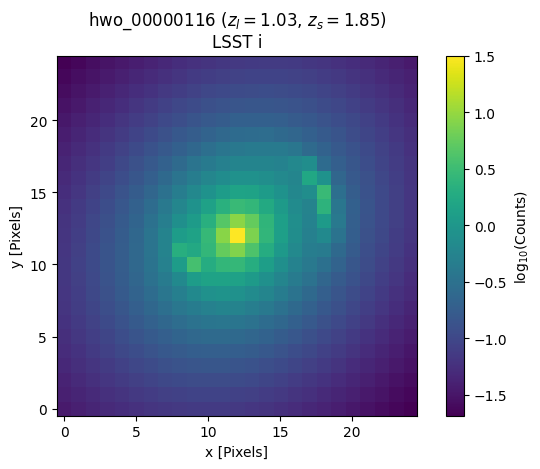

In [45]:
synthetic_image_lsst = SyntheticImage(strong_lens=sample,
                                 instrument=LSST(),
                                 band='i',
                                 verbose=True)
synthetic_image_lsst.plot()

Exposure calculation time with galsim engine: 0.028 s


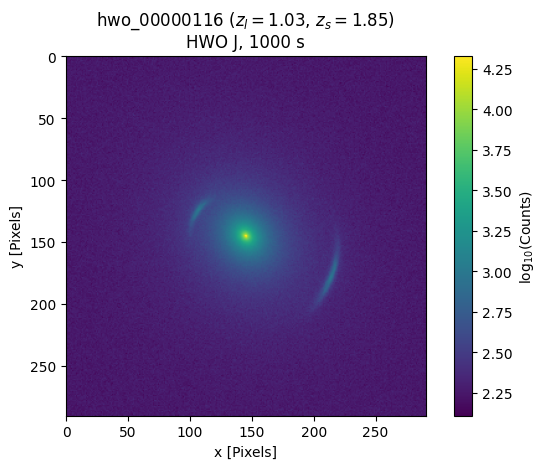

In [52]:
exposure_hwo = Exposure(synthetic_image=synthetic_image_hwo,
                        exposure_time=1000,
                        # engine='lenstronomy',
                        verbose=True)
exposure_hwo.plot()

Exposure calculation time with lenstronomy engine: 0.005 s


/grad/bwedig/mejiro/mejiro/utils/util.py:170: UserWarning: Negative values in array have been replaced with 8.710978246461581e-06.
  warnings.warn(f"Negative values in array have been replaced with {replacement}.")


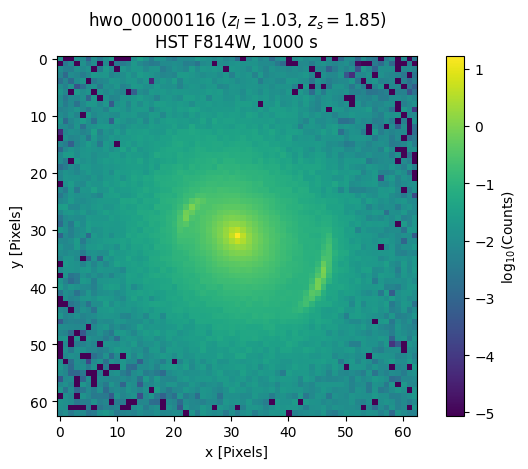

In [47]:
exposure_hst = Exposure(synthetic_image=synthetic_image_hst,
                    exposure_time=1000,
                    engine='lenstronomy',
                    verbose=True)
exposure_hst.plot()

/grad/bwedig/mejiro/mejiro/utils/util.py:170: UserWarning: Negative values in array have been replaced with 1.4695687547406494e-05.
  warnings.warn(f"Negative values in array have been replaced with {replacement}.")


Exposure calculation time with lenstronomy engine: 0.005 s


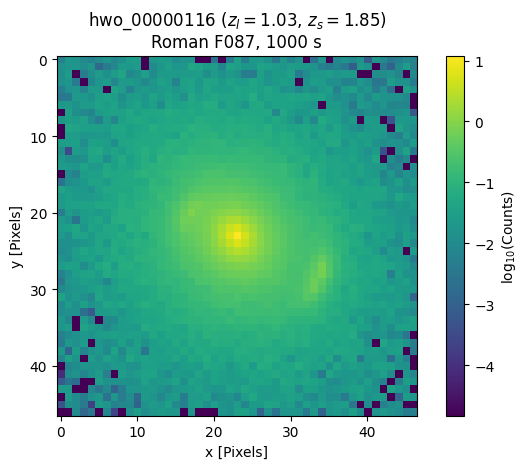

In [48]:
exposure_roman = Exposure(synthetic_image=synthetic_image_roman,
                    exposure_time=1000,
                    engine='lenstronomy',
                    verbose=True)
exposure_roman.plot()

/grad/bwedig/mejiro/mejiro/utils/util.py:170: UserWarning: Negative values in array have been replaced with 0.0005955876267797061.
  warnings.warn(f"Negative values in array have been replaced with {replacement}.")


Exposure calculation time with lenstronomy engine: 0.004 s


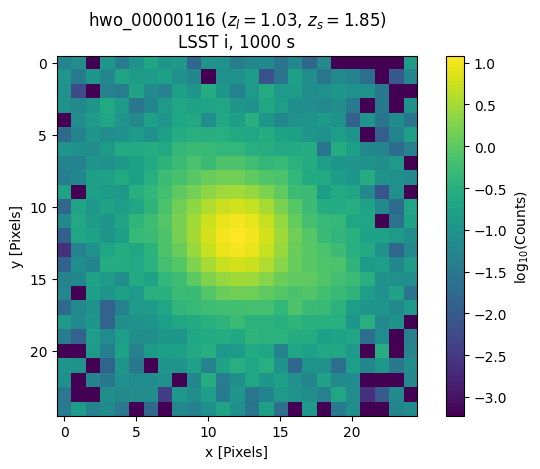

In [49]:
exposure_lsst = Exposure(synthetic_image=synthetic_image_lsst,
                    exposure_time=1000,
                    engine='lenstronomy',
                    verbose=True)
exposure_lsst.plot()

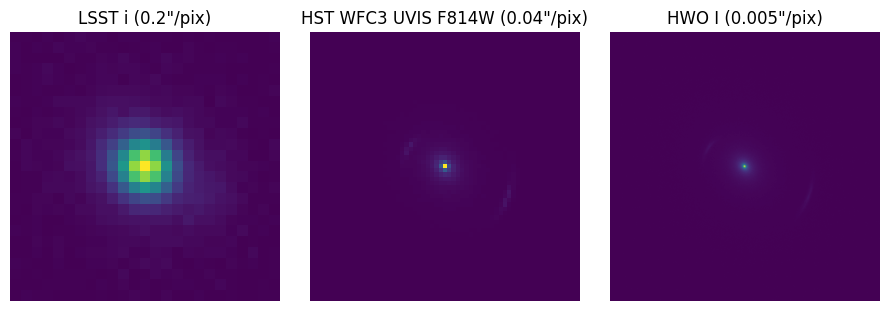

In [55]:
f, ax = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)
ax[0].imshow(exposure_lsst.exposure)
ax[0].set_title('LSST i (0.2"/pix)')
ax[1].imshow(exposure_hst.exposure)
ax[1].set_title('HST WFC3 UVIS F814W (0.04"/pix)')
ax[2].imshow(exposure_hwo.exposure)
ax[2].set_title('HWO I (0.005"/pix)')
for a in ax.flatten():
    a.axis('off')
plt.show()